In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.datasets import mnist
from keras.layers import (
    Conv2D, Dense, Flatten, Input, MaxPooling2D, Reshape, UpSampling2D)
from keras.models import Model, Sequential, load_model
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
# this is the size of our encoded representations
ENCODING_DIM = 10

# decision boundary for classifier
THRESHOLD = 0.7

# working directory
CUR_DIR = os.path.curdir

np.random.seed(42)

In [3]:
def get_data(train_split=.7, test_split=.85):
    """retrieves data MNIST data set and rebalances dataset, such that train=.7, test=.15 and validation=.15"""
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    X_train = X_train.reshape((len(X_train), 28, 28, 1))
    test_len = len(X_test)

    X_test = X_test.reshape((test_len, 28, 28, 1))

    # divide X values bei 255.0 since MNIST data set changed such that pixel values are in [0,255]
    X = np.concatenate((X_train, X_test)) / 255.0
    y = np.concatenate((y_train, y_test))

    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    # define boundaries for train,validation and test set at .7 and .85 % of the MNIST data set
    x_len = len(X)
    boundaries = [int(x_len * 0.7), int(x_len*0.85)]

    [X_train, X_test, X_validate] = np.split(X, boundaries)

    [y_train, y_test, y_validate] = np.split(y, boundaries)

    # non-anomalies
    zero_indices = np.where(y_train == 0)
    zeros_train = X_train[zero_indices]
    # anomalies
    zero_indices = np.where(y_train == 8)
    eights_train = X_train[zero_indices]

    # one-hot encode target columns
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    y_validate = to_categorical(y_validate)

    return (X_train, X_test, X_validate), (y_train, y_test, y_validate)

In [4]:
def build_classifier(input_dim):
    """Builds classifier for classification of MNIST encoded representation."""
    classifier = Sequential()
    classifier.add(Dense(32, activation="relu", input_dim=input_dim,
                         kernel_initializer="random_normal"))
    classifier.add(Dense(ENCODING_DIM, activation="softmax",
                         kernel_initializer="random_normal"))

    classifier.compile(optimizer='adam', loss='mean_squared_error',
                       metrics=['accuracy'])
    return classifier

In [5]:
def build_conv_aue():
    INPUT_SHAPE = (28, 28, 1)
    DEFAULT_KERNEL = (3, 3)
    DEFAULT_POOL_SIZE = (2, 2)
    # this is our input placeholder
    input_img = Input(shape=INPUT_SHAPE)
    # layer between input and middle layer
    encode = Conv2D(16, DEFAULT_KERNEL, activation="relu",
                    padding="same")(input_img)
    encode = MaxPooling2D(DEFAULT_POOL_SIZE, padding="same")(encode)
    encode = Conv2D(8, DEFAULT_KERNEL, activation="relu",
                    padding="same")(encode)
    encode = MaxPooling2D(DEFAULT_POOL_SIZE, padding="same")(encode)
    encode = Conv2D(8, DEFAULT_KERNEL, activation="relu",
                    padding="same")(encode)
    encode = MaxPooling2D(DEFAULT_POOL_SIZE, padding="same")(encode)
    encode = Conv2D(4, DEFAULT_KERNEL, activation="relu",
                    padding="same")(encode)

    # "encoded" is the encoded representation of the input, middle layer of the aue
    encoded = MaxPooling2D(
        DEFAULT_POOL_SIZE, padding="same", name="encoder")(encode)

    # layer between middle and output layer
    decode = Conv2D(4, DEFAULT_KERNEL, activation="relu", padding="same"
                    )(encoded)
    decode = UpSampling2D(DEFAULT_POOL_SIZE)(decode)
    decode = Conv2D(8, DEFAULT_KERNEL, activation="relu", padding="same"
                    )(decode)
    decode = UpSampling2D(DEFAULT_POOL_SIZE)(decode)
    decode = Conv2D(8, DEFAULT_KERNEL, activation="relu", padding="same"
                    )(decode)
    decode = UpSampling2D(DEFAULT_POOL_SIZE)(decode)
    decode = Conv2D(16, DEFAULT_KERNEL, activation="relu")(decode)
    decode = UpSampling2D(DEFAULT_POOL_SIZE)(decode)
    decoded = Conv2D(1, DEFAULT_KERNEL, activation="sigmoid",
                     padding="same")(decode)

    # this model maps an input to its reconstruction
    autoencoder = Model(inputs=input_img, outputs=decoded)

    encoder, decoder = get_codec_from_aue(autoencoder)

    # build (aka "compile") the model
    autoencoder.compile(optimizer="adadelta", loss="binary_crossentropy")
    return autoencoder, encoder, decoder

In [6]:
def get_codec_from_aue(autoencoder):
    encoder_layer = autoencoder.get_layer("encoder")
    # this model maps an input to its encoded representation; Big image to small rep
    encoder = Model(
        inputs=autoencoder.input, outputs=encoder_layer.output)

    # create a placeholder for an encoded (ENCODING_DIM-dimensional) input
    encoded_input = Input(shape=encoder_layer.output_shape[1:])

    # getting the middle of the autoencoder
    start = (len(autoencoder.layers))//2
    decoder = autoencoder.layers[-start](encoded_input)
    # stacking the decoder layers
    for i in range(start-1, 0, -1):
        decoder = autoencoder.layers[-i](decoder)

    # create the decoder model; "<": encoded(small) representation to big image
    decoder = Model(encoded_input, decoder)
    return encoder, decoder

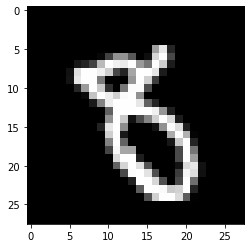

In [7]:
(X_train, X_test, X_validate), (y_train, y_test, y_validate) = get_data()
plt.imshow(X_train[2].reshape((28,28)),cmap="gray")

In [8]:
ckpt_loc = os.path.join(CUR_DIR, "ckpts", "conv-aue.hdf5")

if(os.path.isfile(ckpt_loc)):
    print("Loading Autoencoder from directory %s..." % ckpt_loc)
    autoencoder = load_model(ckpt_loc)
    encoder, decoder = get_codec_from_aue(autoencoder)
else:
    print("Training Autoencoder...")
    autoencoder, encoder, decoder = build_conv_aue()
    earlyStopping = EarlyStopping(
        monitor='val_loss', patience=10, verbose=1, mode='min', min_delta=0.0005)
    mcp_save = ModelCheckpoint(ckpt_loc,
                               save_best_only=True, verbose=1, monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(
        monitor='val_loss', factor=0.3, patience=3, verbose=1, mode='min')
    autoencoder.fit(X_train, X_train,
                    epochs=128,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(X_validate, X_validate), callbacks=[earlyStopping, mcp_save, reduce_lr_loss])
    model_path = os.path.join(CUR_DIR, "model", "conv")
    autoencoder.save(os.path.join(model_path, "autoencoder.h5"))
    encoder.save(os.path.join(model_path, "encoder.h5"))
    decoder.save(os.path.join(model_path, "decoder.h5"))
autoencoder.summary()

Loading Autoencoder from directory .\ckpts\conv-aue.hdf5...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)           

In [9]:
eval_train = autoencoder.evaluate(X_train, X_train)
eval_validate = autoencoder.evaluate(X_validate, X_validate)
eval_test = autoencoder.evaluate(X_test, X_test)
eval_train, eval_validate,eval_test

10500/10500 [==============================] - 2s 187us/step


(0.13687659084067053, 0.13702945776496614, 0.13799697311719258)

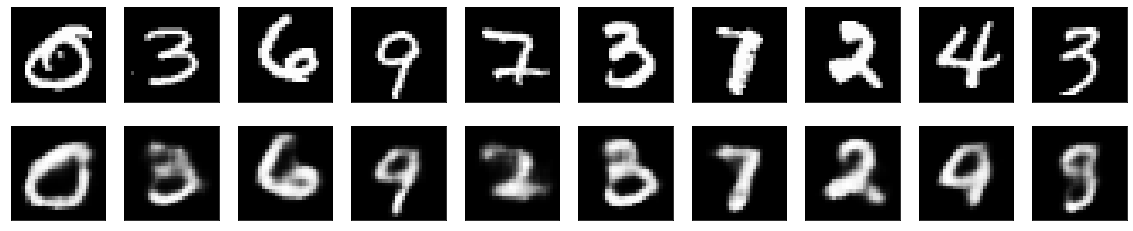

In [10]:
encoded_imgs_train = encoder.predict(X_train)
encoded_imgs_validate = encoder.predict(X_validate)
encoded_imgs_test = encoder.predict(X_test)

decoded_imgs = decoder.predict(encoded_imgs_test)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig(os.path.join("imgs", "conv-autoencoder.png"))

In [11]:
flat = np.prod(encoded_imgs_train.shape[1:], dtype=np.int64)
encoded_imgs_train = encoded_imgs_train.reshape(len(encoded_imgs_train), flat)
encoded_imgs_validate = encoded_imgs_validate.reshape(
    len(encoded_imgs_validate), flat)
encoded_imgs_test = encoded_imgs_test.reshape(len(encoded_imgs_test), flat)

In [12]:
ckpt_loc = os.path.join(CUR_DIR, "ckpts", "classifier.hdf5")
if(os.path.isfile(ckpt_loc)):
    print("Loading classifier from directory %s..." % ckpt_loc)
    classifier = load_model(ckpt_loc)
else:
    print("Training classifier...")
    classifier = build_classifier(input_dim=flat)
    earlyStopping = EarlyStopping(
        monitor='val_acc', patience=5, verbose=1, mode='max',  min_delta=0.0005)
    mcp_save = ModelCheckpoint(ckpt_loc,
                               save_best_only=True, verbose=1, monitor='val_acc', mode='max')
    reduce_lr_loss = ReduceLROnPlateau(
        monitor='val_acc', factor=0.3, patience=3, verbose=1, mode='max')
    classifier.fit(encoded_imgs_train, y_train, validation_data=(
        encoded_imgs_validate, y_validate), batch_size=16, epochs=32, shuffle=True, callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

Loading classifier from directory .\ckpts\classifier.hdf5...


In [13]:
eval_train = classifier.evaluate(encoded_imgs_train, y_train)
eval_validate = classifier.evaluate(encoded_imgs_validate, y_validate)
eval_test = classifier.evaluate(encoded_imgs_test, y_test)
eval_train,eval_validate, eval_test

10500/10500 [==============================] - 1s 86us/step


([0.021673000293422718, 0.8574489795918367],
 [0.021721618068360145, 0.8558095238095238],
 [0.021641030059151706, 0.858])

In [14]:
def get_cm(input, y_true):
    """Computes confusion matrix."""
    y_pred = tf.argmax(classifier.predict(input), axis=1)
    y_true = tf.argmax(y_true, axis=1)

    c = tf.keras.backend.eval(y_pred)
    d = tf.keras.backend.eval(y_true)

    return confusion_matrix(c, d)

In [15]:
def precision(cm):
    results = []
    for i in range(len(cm)):  # rows
        TP = cm[i][i]
        fp_tp = np.sum(cm[i])
        results.append(TP/fp_tp)
    return results + [np.mean(results)]

In [16]:
def recall(cm):
    results = []
    for i in range(len(cm)):  # rows
        TP = cm[i][i]
        tp_fn = 0
        for j in range(len(cm[i])):
            tp_fn += cm[j][i]
        results.append(TP/tp_fn)
    return results + [np.mean(results)]

In [17]:
cm_train = get_cm(encoded_imgs_train, y_train)
print(cm_train, precision(cm_train)[-1], recall(cm_train)[-1], sep="\n")

cm_validate = get_cm(encoded_imgs_validate, y_validate)
print(cm_validate, precision(cm_validate)[-1], recall(cm_validate)[-1], sep="\n")

cm_test = get_cm(encoded_imgs_test, y_test)
print(cm_test, precision(cm_test)[-1], recall(cm_test)[-1], sep="\n")

[[4639    2   38   28    3  178  184   10  123   49]
 [   3 5296   15   17   26   42   72   43   94   50]
 [   6   39 4200  199   73   33   41   45  132   29]
 [  10   49  146 4007    0  277    5   25  134   43]
 [   8   14   77    6 3842   78   87   62   41  103]
 [  54   26   21  298   12 3464  102   23  183   93]
 [  83    9   78   28   92  111 4343    2   24   10]
 [   1    1   53  115  157   48    2 4332   50  416]
 [  55   30  257  198   38  111   30   89 3806   32]
 [   3   11    4   45  475  102    2  513  159 4086]]
0.8569204237780838
0.8553180962638333
[[ 970    0   13    6    2   45   45    2   29   16]
 [   0 1164    2    5    6    7   23    8   17   10]
 [   1   14  935   41   17    7    5    8   26    2]
 [   2    9   30  853    1   84    2    8   30   10]
 [   0    2   16    3  816   21   17    7    4   22]
 [  15    7    2   62    6  727   22    7   32   23]
 [  17    1   14    6   21   25  902    1    7    1]
 [   0    2   12   13   31    7    0  940   11   81]
 [  13 

In [51]:
def gauss(x_i, my_i, sigma_i2):
    # gaussian distribution for one feature
    if sigma_i2 == 0:
        return 1 if x_i == my_i  else 0
    return np.array((1/np.sqrt(2*np.pi*sigma_i2)) *
                    np.exp(-(x_i-my_i)**2/(2*sigma_i2)))

In [52]:
def my(X):
    return np.array([(1 / len(x)) * np.sum(x) for x in X.T])

In [53]:
def sigma2(X, my):
    # computes sigma squared for each feature
    m = len(X)  # number of data points
    return np.array([np.sum((X[:, i] - my[i]) ** 2)/m for i in range(len(my))])

In [54]:
def p(X,my,sigma2):
    return np.array([np.prod([gauss(x[i], my_train[i], sigma2_train[i])
               for i in range(len(my_train))]) for x in X])

In [66]:
X = encoded_imgs_train[np.where(np.argmax(y_train,axis=1) == 3)]
m = len(X)
my =  np.array([(1 / len(x)) * np.sum(x) for x in X.T])
sigma_2 =  np.array([np.sum((X[:, i] - my[i]) ** 2)/m for i in range(len(my))])
epsilon = 1*10e-10

thresholded = p(X,my,sigma_2)>epsilon
len(np.where(thresholded))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()